In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import normalize_data
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 12)

# Load and Prepare Dataset

In [2]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

# Load Data
df = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/tims/sample2_test.pkl')

# Normalize
norm_df = normalize_data.normalize_all_columns(df).dropna()

# Split into X,y
ref, X, y = get_ref_X_y(df)

# Limit y columns
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG', 'y_BSTAR']
y=y[y_cols]

# Load Models and Make Predictions

In [3]:
from dataset import Dataset, to_device

def predict(model, X, y, device='cpu'):
    pyt_device = torch.device(device)

    if 'cuda' in device:
        to_device(model, pyt_device)
        # Since it doesn't all fit on the GPU, we'll use a dataloader
        batch_size = 2000
        predictDataset = Dataset(X, y)
        predictLoader = torch.utils.data.DataLoader(dataset=predictDataset,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=5,
                                                  pin_memory=True
                                                 )
        num_elements = len(predictLoader.dataset)
        num_outputs = len(y.columns)
        num_batches = len(predictLoader)
        predictions = torch.zeros(num_elements, num_outputs)
        for i, (inputs, _) in tqdm(enumerate(predictLoader), total=num_batches):
            inputs = to_device(inputs, pyt_device)
            start = i*batch_size
            end = start + batch_size
            if i == num_batches - 1:
                end = num_elements
            pred = model(inputs)
            predictions[start:end] = pred.detach().cpu()
        nn_results = predictions.numpy()
    else:
        X_tensor = torch.from_numpy(X.to_numpy()).float()
        nn_results = model(X_tensor).detach().numpy()

    return nn_results

def load_model(name,path='models'):
    print(f"{path}/{name}.pth")
    cp = torch.load(f"{path}/{name}.pth")
    return cp['net']

In [4]:
# Create or load all new sub models here if needed.
pred_data = {}
y_dummy=pd.DataFrame(np.zeros(len(y)))

for col in y_cols:
    pred_data[col] = predict(load_model(col), X, y_dummy, device="cuda").reshape(-1)
    
y_pred = pd.DataFrame(pred_data)

models/y_INCLINATION.pth


  0%|          | 0/632 [00:00<?, ?it/s]

models/y_ECCENTRICITY.pth


  0%|          | 0/632 [00:00<?, ?it/s]

models/y_MEAN_MOTION.pth


  0%|          | 0/632 [00:00<?, ?it/s]

models/y_RA_OF_ASC_NODE_REG.pth


  0%|          | 0/632 [00:00<?, ?it/s]

models/y_ARG_OF_PERICENTER_REG.pth


  0%|          | 0/632 [00:00<?, ?it/s]

models/y_REV_MA_REG.pth


  0%|          | 0/632 [00:00<?, ?it/s]

models/y_BSTAR.pth


  0%|          | 0/632 [00:00<?, ?it/s]

# Compare Ground Truth to Predicted

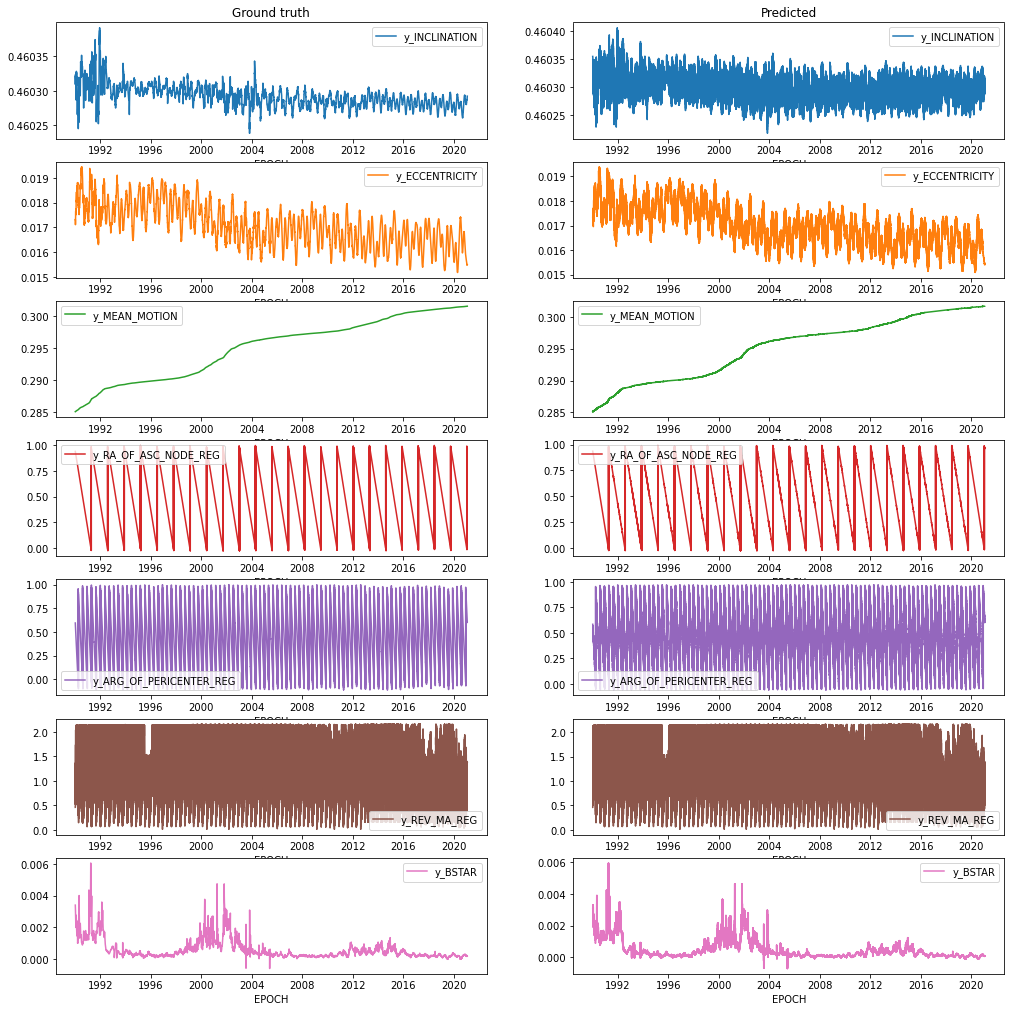

In [7]:
mask_12701 = ref.__NORAD_CAT_ID_1 == 12701
graph_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG',
              'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG', 'y_BSTAR']
n = len(graph_cols)

fig, axs = plt.subplots(n,2,figsize=(17,n*2.5))

y_test_12701 = y[mask_12701].copy()
y_test_12701['EPOCH'] = ref[ref.__NORAD_CAT_ID_1 == 12701]['__EPOCH_2']
y_test_12701.set_index('EPOCH')[graph_cols].plot(figsize=[14,14], subplots=True, ax=axs[:,0])

y_pred_12701 = y_pred[mask_12701].copy()
y_pred_12701['EPOCH'] = ref[ref.__NORAD_CAT_ID_1 == 12701]['__EPOCH_2']
y_pred_12701.set_index('EPOCH')[graph_cols].plot(figsize=[14,14], subplots=True, ax=axs[:,1])

axs[0,0].set_title('Ground truth')
axs[0,1].set_title('Predicted')
plt.show()

In [8]:
X

,X_delta_EPOCH,X_EPOCH_JD_1,X_EPOCH_FR_1,X_EPOCH_JD_2,X_EPOCH_FR_2,X_MEAN_MOTION_DOT_1,X_BSTAR_1,X_INCLINATION_1,X_RA_OF_ASC_NODE_1,X_ECCENTRICITY_1,X_ARG_OF_PERICENTER_1,X_MEAN_ANOMALY_1,X_MEAN_MOTION_1,X_MEAN_ANOMALY_COS_1,X_MEAN_ANOMALY_SIN_1,X_INCLINATION_COS_1,X_INCLINATION_SIN_1,X_RA_OF_ASC_NODE_COS_1,X_RA_OF_ASC_NODE_SIN_1,X_SEMIMAJOR_AXIS_1,X_PERIOD_1,X_APOAPSIS_1,X_PERIAPSIS_1,X_RCS_SIZE_1,X_SAT_RX_1,X_SAT_RY_1,X_SAT_RZ_1,X_SAT_VX_1,X_SAT_VY_1,X_SAT_VZ_1,X_YEAR_1,X_DAY_OF_YEAR_COS_1,X_DAY_OF_YEAR_SIN_1,X_SUNSPOTS_1D_1,X_SUNSPOTS_3D_1,X_SUNSPOTS_7D_1,X_AIR_MONTH_AVG_TEMP_1,X_WATER_MONTH_AVG_TEMP_1
0,0.135120082855,0.000350477526,0.058858550000,0.000438096907,0.004699129988,0.00026210,0.00692640,0.346109444444,0.622566666667,0.2439684,0.882507777778,0.105120277778,0.284982781714,0.789691596026,0.613504020497,0.464846681628,0.885391191835,-0.717834731500,-0.696213543571,0.4310505,21.394666666667,0.341793846154,0.111522051282,0.333333333333,-0.629936051846,-0.610941796125,-0.000028116404,0.284989309534,-0.347021886645,0.852908595439,0.000000000000,0.996318363448,0.085730500156,0.420,0.430666666667,0.468857142857,0.423,0.441
1,0.145515520002,0.000438096907,0.659555169988,0.000525716288,0.678163810000,0.00018502,0.00487400,0.346195000000,0.610089722222,0.2444256,0.883478611111,0.104065833333,0.285006766857,0.793738864597,0.608258674273,0.464608688772,0.885516101671,-0.770153778099,-0.637858258612,0.4310130,21.394222222222,0.341989230769,0.111288205128,0.333333333333,-0.675853402712,-0.559196416980,-0.000821796346,0.256301093916,-0.368696682193,0.853311724671,0.000000000000,0.994699875615,0.102820997137,0.370,0.412000000000,0.443714285714,0.423,0.441
2,0.135113774287,0.000788574433,0.952180209988,0.000876193814,0.897976630000,0.00009885,0.00263790,0.346191666667,0.576401388889,0.2438196,0.886425000000,0.101568055556,0.285074449143,0.803186737163,0.595727341362,0.464617961849,0.885511236251,-0.886974564791,-0.461818277479,0.4309070,21.393111111111,0.341645641026,0.111523333333,0.333333333333,-0.777606069280,-0.404869351523,-0.000007387667,0.174882965796,-0.413716327726,0.853829860564,0.000000000000,0.985300562686,0.170829743225,0.344,0.339333333333,0.369142857143,0.423,0.441
3,0.187076012855,0.000963813195,0.625502940000,0.001051432577,0.935035029988,0.00009431,0.00251870,0.346188888889,0.563279722222,0.2437496,0.887556944444,0.100518888889,0.285106883429,0.807096356505,0.590419741638,0.464625689375,0.885507181661,-0.921993633347,-0.387205036211,0.4308565,21.392666666667,0.341585128205,0.111531794872,0.333333333333,-0.808110131883,-0.339300237164,-0.000136478802,0.140414257332,-0.426766860056,0.854050959312,0.000000000000,0.978855685095,0.204552066126,0.442,0.402000000000,0.368571428571,0.423,0.441
4,0.280607920002,0.001051432577,0.935035029988,0.001226671340,0.899290470000,0.00009370,0.00250030,0.346183333333,0.553012500000,0.2437832,0.888445277778,0.099736388889,0.285134531429,0.809989443183,0.586444457671,0.464641144320,0.885499072278,-0.945037398539,-0.326962253727,0.4308135,21.392222222222,0.341577435897,0.111495128205,0.333333333333,-0.828093996682,-0.286503815258,0.000002553669,0.113024774319,-0.434909148071,0.854233672255,0.000000000000,0.975200040245,0.221325284382,0.460,0.440666666667,0.381428571429,0.423,0.441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263166,1.832408758571,0.965740821870,0.337698660000,0.966879873828,0.164559970000,0.00263535,0.00030590,0.294416111111,0.129252222222,0.0042576,0.300036111111,0.700573055556,0.552256242286,-0.305590611021,-0.952162999941,0.601886108746,0.798581938250,0.687964542985,0.725744299044,0.0649280,18.008666666667,0.040712307692,0.037093333333,0.666666666667,0.570402670847,0.601726484395,-0.000000000912,-0.424462473930,0.399811652888,0.774248070185,0.967741935484,0.423914390710,0.905702263080,0.000,0.000000000000,0.000000000000,1.171,1.082
1263167,1.999327761429,0